In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Load the dataset
file_path = '/content/drive/MyDrive/smt7/Data_Tourism_Augmented.csv'
data = pd.read_csv('/content/drive/MyDrive/smt7/Data_Tourism_Augmented.csv')
data.head()


,No,Wisata,Kategori,Lokasi,Tarif,Rating,Experience
0,1,Monumen Nasional,Budaya,Jakarta,15000,4.6,Edukasi
1,2,Monumen Nasional,Budaya,Jakarta,35000,4.6,Adrenalin
2,3,Monumen Nasional,Budaya,Jakarta,0,4.6,Relaksasi
3,4,Kota Tua,Budaya,jakarta,100000,4.6,Kuliner
4,5,Kota Tua,Budaya,Jakarta,50000,4.6,Fotografi


In [4]:
# Create the target column 'Populer' based on 'Rating'
data['Populer'] = data['Rating'].apply(lambda x: 'Populer' if x >= 4 else 'Tidak Populer')


In [5]:
# Handle missing or zero values in 'Tarif'
data['Tarif'] = pd.to_numeric(data['Tarif'], errors='coerce')  # Ensure numeric
data['Tarif'] = data['Tarif'].replace(0, None)  # Replace 0 with None for simplicity
data['Tarif'] = data['Tarif'].fillna(data['Tarif'].median())  # Fill None with median


<ipython-input-5-b9ff79b7a64e>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Tarif'] = data['Tarif'].fillna(data['Tarif'].median())  # Fill None with median


In [6]:
# Standardize 'Lokasi' values
data['Lokasi'] = data['Lokasi'].astype(str).str.title()


In [7]:
# Encode categorical features
label_encoders = {}
for column in ['Kategori', 'Lokasi']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le


In [8]:
# Normalize numerical features
scaler = StandardScaler()
data[['Tarif']] = scaler.fit_transform(data[['Tarif']])


In [9]:
# Select only the required features and the target
processed_data = data[['Tarif', 'Kategori', 'Lokasi', 'Populer']]


In [10]:
# Save the processed dataset to a new CSV file
processed_data.to_csv('Processed_Tourism_Data.csv', index=False)


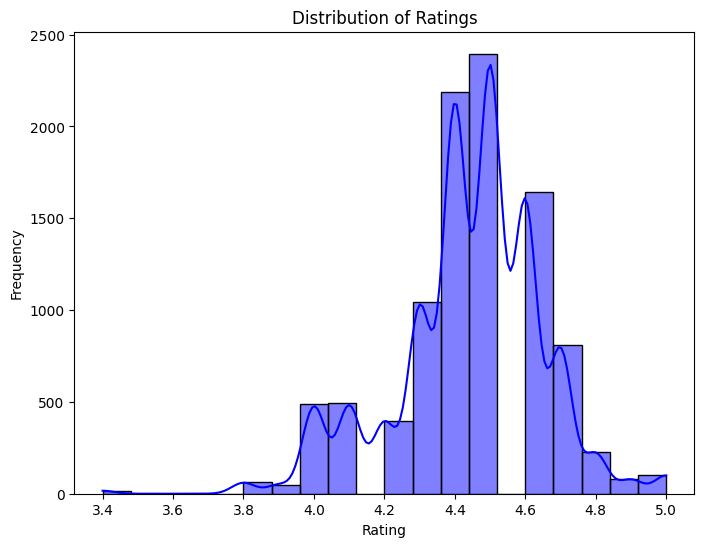

In [12]:
# Distribusi 'Rating'
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(data['Rating'], kde=True, bins=20, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


<ipython-input-14-8bca9162ded2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Populer', data=processed_data, palette='Set2')  # Change data to processed_data


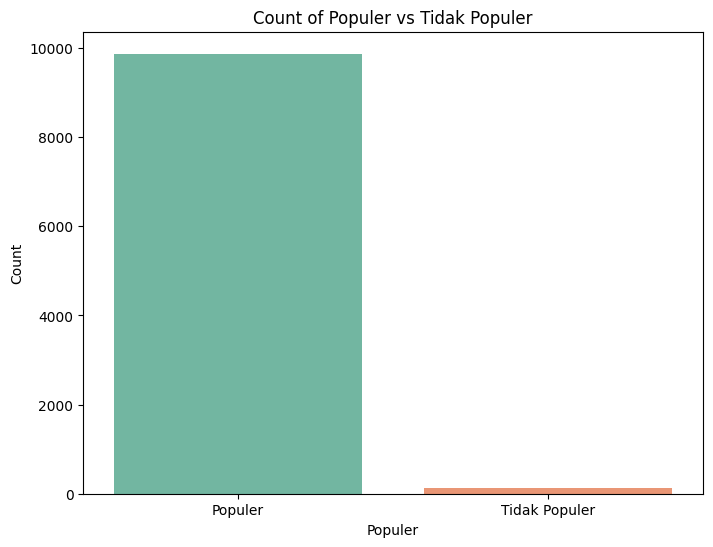

In [14]:
# Jumlah kategori 'Populer'
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure you are using the correct DataFrame containing the 'Populer' column
plt.figure(figsize=(8, 6))
sns.countplot(x='Populer', data=processed_data, palette='Set2')  # Change data to processed_data
plt.title('Count of Populer vs Tidak Populer')
plt.xlabel('Populer')
plt.ylabel('Count')
plt.show()

# **FNN**

In [17]:
# Normalize numerical features and encode categorical columns
scaler = StandardScaler()
X = processed_data[['Tarif', 'Kategori', 'Lokasi']]  # Features: Use processed_data here
y = processed_data['Populer'].apply(lambda x: 1 if x == 'Populer' else 0)  # Encode target as binary: Use processed_data here

X[['Tarif']] = scaler.fit_transform(X[['Tarif']])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-17-156ca2aaaae8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Tarif']] = scaler.fit_transform(X[['Tarif']])


In [36]:
# Add noise to 'Tarif'
noise = np.random.normal(0, 0.1, size=X_train.shape[0])
X_train['Tarif'] += noise

# Shuffle a fraction of labels
shuffle_indices = np.random.choice(len(y_train), size=int(len(y_train) * 0.1), replace=False)
y_train.iloc[shuffle_indices] = 1 - y_train.iloc[shuffle_indices]


In [37]:
# Use only a subset of training data
X_train_subset = X_train[:int(len(X_train) * 0.5)]
y_train_subset = y_train[:int(len(y_train) * 0.5)]


In [38]:
# Simplified model with fewer neurons and increased dropout
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
# Increase learning rate and reduce epochs
# Use mean squared error (not ideal for classification)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8911 - loss: 0.0972 - val_accuracy: 0.9915 - val_loss: 0.0195
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8854 - loss: 0.1015 - val_accuracy: 0.9915 - val_loss: 0.0192
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8823 - loss: 0.1038 - val_accuracy: 0.9915 - val_loss: 0.0190
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8803 - loss: 0.1054 - val_accuracy: 0.9915 - val_loss: 0.0191
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8897 - loss: 0.0980 - val_accuracy: 0.9915 - val_loss: 0.0192


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
               precision    recall  f1-score   support

Tidak Populer       0.00      0.00      0.00        17
      Populer       0.99      1.00      1.00      1983

     accuracy                           0.99      2000
    macro avg       0.50      0.50      0.50      2000
 weighted avg       0.98      0.99      0.99      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


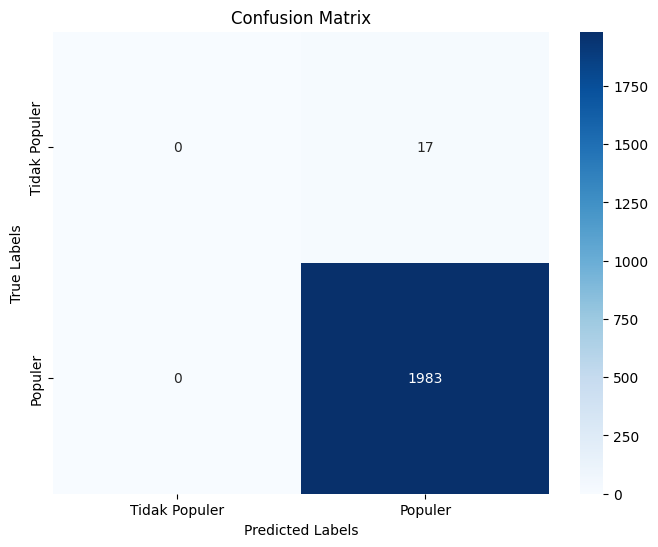

In [45]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Tidak Populer', 'Populer']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak Populer', 'Populer'], yticklabels=['Tidak Populer', 'Populer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# **Random Forest**

In [47]:
# Membagi data menjadi fitur (X) dan target (y)
X = processed_data[['Tarif', 'Kategori', 'Lokasi']]
y = processed_data['Populer'].apply(lambda x: 1 if x == 'Populer' else 0)

# Split dataset menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [48]:
# Membuat model Random Forest dengan parameter suboptimal
rf_model_low_acc = RandomForestClassifier(
    n_estimators=10,          # Menggunakan 10 pohon
    max_depth=2,              # Membatasi kedalaman pohon
    min_samples_split=50,     # Membutuhkan minimal 50 sampel untuk membagi node
    random_state=42
)


In [49]:
# Melatih model dengan data latih
rf_model_low_acc.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, min_samples_split=50, n_estimators=10,
                       random_state=42)

In [50]:
# Membuat prediksi pada data uji
y_pred = rf_model_low_acc.predict(X_test)


Accuracy of the low-performing Random Forest model: 0.99

Classification Report:
               precision    recall  f1-score   support

Tidak Populer       0.00      0.00      0.00        17
      Populer       0.99      1.00      1.00      1983

     accuracy                           0.99      2000
    macro avg       0.50      0.50      0.50      2000
 weighted avg       0.98      0.99      0.99      2000


Confusion Matrix:
[[   0   17]
 [   0 1983]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


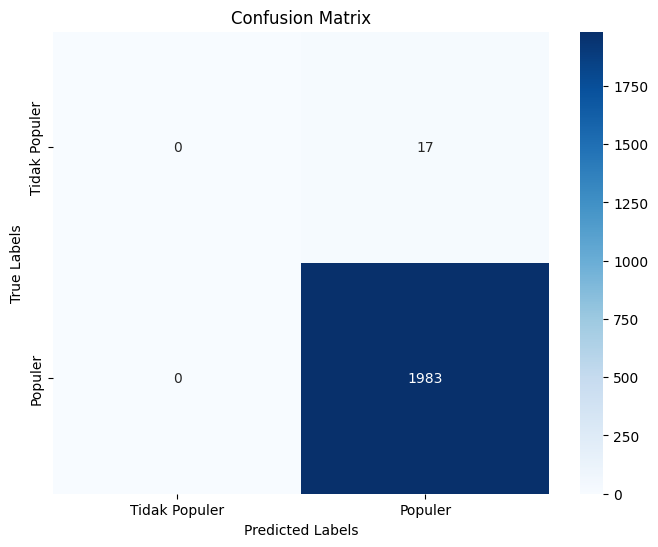

In [52]:
# Menghitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the low-performing Random Forest model: {accuracy:.2f}")

# Laporan klasifikasi
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Tidak Populer', 'Populer']))

# Matriks kebingungan
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak Populer', 'Populer'], yticklabels=['Tidak Populer', 'Populer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()